In [20]:
# Regularization: Ridge, LASSO, Elastic Net
# based on D. Bette that was based on J. Nagler
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Define models

In [21]:
# Min: ||y - Xw||^2_2 + alpha * ||w||^2_2
def do_ridge(lambdaaa,X_train,y_train,X_test,y_test):
    ridge = Ridge(alpha=lambdaaa, max_iter=int(10e5))
    ridge.fit(X_train,y_train)
    ridge_train_score=ridge.score(X_train,y_train)
    ridge_test_score=ridge.score(X_test,y_test)
    ridge_num_features = np.sum(ridge.coef_!=0)
    ridge_coef = ridge.coef_
    return [round(lambdaaa, 4), round(ridge_train_score, 4), round(ridge_test_score, 4), ridge_num_features], list(ridge_coef)

# Min: cN ||y - Xw||^2_2 + alpha * ||w||_1
def do_lasso(lambdaaa,X_train,y_train,X_test,y_test): #do not use "lambda" as variable
    lasso = Lasso( alpha=lambdaaa )
    lasso.fit( X_train,y_train )
    lasso_train_score=lasso.score( X_train,y_train )
    lasso_test_score=lasso.score( X_test,y_test )
    lasso_num_features = np.sum( lasso.coef_!=0 )
    lasso_coef = lasso.coef_
    return [round(lambdaaa, 4), round(lasso_train_score, 4), round(lasso_test_score, 4), lasso_num_features], list(lasso_coef)

# Min: cN ||y - Xw||^2_2 + c1 ||w||_1 + c2 ||w||^2_2
def do_elastic(lambdaaa,X_train,y_train,X_test,y_test):
    elast = ElasticNet(alpha=lambdaaa, l1_ratio=0.5, max_iter=int(10e5)) # L1-Ratio is set to fixed value for comparison
    elast.fit(X_train,y_train)
    elast_train_score=elast.score(X_train,y_train)
    elast_test_score=elast.score(X_test,y_test)
    elast_num_features = np.sum(elast.coef_!=0)
    elast_coef = elast.coef_
    return [round(lambdaaa, 4), round(elast_train_score, 4), round(elast_test_score, 4), elast_num_features], list(elast_coef)

In [22]:
#package 

def compare(X,y,feature_names):
    #X = pd.get_dummies(X)
    # Split data into train and test datasets and use statify sampling
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2,
                                                        #stratify=y, 
                                                        random_state=42)
    
    sc = MinMaxScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    results, coefficient = [], []

    for i in np.logspace(-4, np.log10(1), 100):   
        run, coef_run = do_lasso(i,X_train,y_train,X_test,y_test)
        results.append(run)
        coefficient.append(coef_run)
    temp_1,temp_2 = [],[]
    temp_1 = pd.DataFrame(results, columns=["Lambda", "Train Score", "Test Score", "Number of features"])
    temp_2 = pd.DataFrame(coefficient, columns=feature_names)
    lasso_results = pd.concat([temp_1, temp_2], axis=1)

    results, coefficient = [], []

    for i in np.logspace(-4, np.log10(1), 100):    
        run, coef_run = do_ridge(i,X_train,y_train,X_test,y_test)
        results.append(run)
        coefficient.append(coef_run)

    temp_1 = pd.DataFrame(results, columns=["Lambda", "Train Score", "Test Score", "Number of features"])
    temp_2 = pd.DataFrame(coefficient, columns=feature_names)
    ridge_results = pd.concat([temp_1, temp_2], axis=1)   

    results, coefficient = [], []

    for i in  np.logspace(-4, np.log10(1), 100):     
        run, coef_run = do_elastic(i,X_train,y_train,X_test,y_test)
        results.append(run)
        coefficient.append(coef_run)

    temp_1 = pd.DataFrame(results, columns=["Lambda", "Train Score", "Test Score", "Number of features"])
    temp_2 = pd.DataFrame(coefficient, columns=feature_names)
    elastic_results = pd.concat([temp_1, temp_2], axis=1)

    elastic_cv = ElasticNetCV(l1_ratio=np.linspace(0.001, 0.999, num=10), 
                            n_alphas=100,
                            cv=10, 
                            random_state=42)

    elastic_cv.fit(X_train,y_train)
    elastic_cv_train_score=round(elastic_cv.score(X_train,y_train), 4)
    elastic_cv_test_score=round(elastic_cv.score(X_test,y_test), 4)
    elastic_cv_num_features = np.sum(elastic_cv.coef_!=0)
    lambda1 = round(elastic_cv.alpha_, 4)

    plot_names = ["LASSO", "RIDGE", "ElasticNet"]
    plot_data = [lasso_results, ridge_results, elastic_results]

    plt.figure(figsize=(18, 6))
    for i in range(0,3):
        name = plot_names[i]
        data = plot_data[i]
        plt.subplot(1, 3, i+1)
        if i == 2:
            plt.plot(np.ones(5)*lambda1,np.linspace(0,1,5),label= "cv lambda")
        plt.plot(data["Lambda"], data["Train Score"], label="Train Score")
        plt.plot(data["Lambda"], data["Test Score"], label="Test Score")
        plt.xlabel("Lambda")
        plt.ylabel("Score")
        #plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xscale('log')
        plt.legend()
        plt.title(name)
    plt.show()

    plot_names = ["LASSO", "RIDGE", "ElasticNet"]
    plot_data = [lasso_results, ridge_results, elastic_results]

    plt.figure(figsize=(12, 6))
    for i in range(1,3):
        plt.subplot(1,2,i)
        for name, data in zip(plot_names, plot_data):
            plt.plot(data["Lambda"], data["Number of features"], label=name)    
        plt.xlabel("Lambda")
        plt.ylabel("Number of features")
        if i == 1:
            plt.xscale('log')
        plt.legend()
        plt.title("Comparison of the number of features \nover different Lambdas")
    plt.show()

    # Plot coefficients

    plot_names = ["LASSO", "RIDGE", "ElasticNet"]
    plot_data = [lasso_results, ridge_results, elastic_results]
    coefficient_names = feature_names

    plt.figure(figsize=(18, 6))
    for i in range(0,3):
        name = plot_names[i]
        data = plot_data[i]
        plt.subplot(1, 3, i+1)
        if i == 2:
            plt.plot(np.ones(5)*lambda1,np.linspace(-data.values.max(),data.values.max(),5),label= "cv lambda")
        for column in coefficient_names:
            plt.plot(data["Lambda"], data[column], label=str(column))
            plt.ylim(-data.values.max()*1.1, data.values.max()*1.1)
            plt.xlabel("Lambda")
            plt.ylabel("Coefficient")
            plt.xscale('log')
            plt.title(name)
            plt.legend()
    plt.show()

    print("The cross validated elastic net result:")
    print("Train Score: " + str(elastic_cv_train_score))
    print("Test Score: " + str(elastic_cv_test_score))
    print("L1 Ratio: " + str(round(elastic_cv.l1_ratio_, 1)))
    print("Lambda: " + str(round(elastic_cv.alpha_, 4)))
    
    # Fit Elastic Net with the best parameters found from cross-validation
    elastic_net_best = ElasticNet(alpha=round(elastic_cv.alpha_, 4), l1_ratio=round(elastic_cv.l1_ratio_, 1), max_iter=10000)
    elastic_net_best.fit(X_train, y_train)

    # Coefficients from the best Elastic Net model
    elastic_net_coeffs = elastic_net_best.coef_

    # Plotting the coefficients for Elastic Net
    plt.figure(figsize=(10, 5))
    plt.barh(feature_names, elastic_net_coeffs, color='teal')
    plt.xlabel('Coefficient Value')
    plt.title('Elastic Net Best Coefficients')
    plt.show()

In [23]:
### heatmap for the correlation matrix
def heatmap(df, name):
    corr_matrix = df.corr()

    plt.figure(figsize=(10, 8))

    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)

    plt.title(f'Feature Correlation Matrix {name}')
    # Show the plot
    plt.show()

In [24]:
### Important features sorted
def important_features(X,y, feature_names):

    # Assuming X_train is your feature set and y_train is the target variable
    # Fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Get the coefficients
    coefficients = model.coef_

    # Create a pandas series with feature names and coefficients
    feature_importance = pd.Series(coefficients, index=feature_names)

    # Sort the features based on the absolute values of their coefficients
    sorted_features = feature_importance.abs().sort_values(ascending=False)

    # Plot the sorted coefficients for visualization
    plt.figure(figsize=(10, 8))
    sorted_features.plot(kind='bar')
    plt.title('Feature Importance based on Linear Model Coefficients')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Magnitude')
    plt.show()
    


### Boston housing prices datasets

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978. Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley, 1980. N.B. Various transformations are used in the table on pages 244-261 of the latter. Variables in order: CRIM per capita crime rate by town ZN proportion of residential land zoned for lots over 25,000 sq.ft. INDUS proportion of non-retail business acres per town CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) NOX nitric oxides concentration (parts per 10 million) RM average number of rooms per dwelling AGE proportion of owner-occupied units built prior to 1940 DIS weighted distances to five Boston employment centres RAD index of accessibility to radial highways TAX full-value property-tax rate per $10,000 PTRATIO pupil-teacher ratio by town B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town LSTAT % lower status of the population MEDV Median value of owner-occupied homes in $1000's

https://www.openml.org/search?type=data&status=active&id=531

c:\Users\WANG-\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


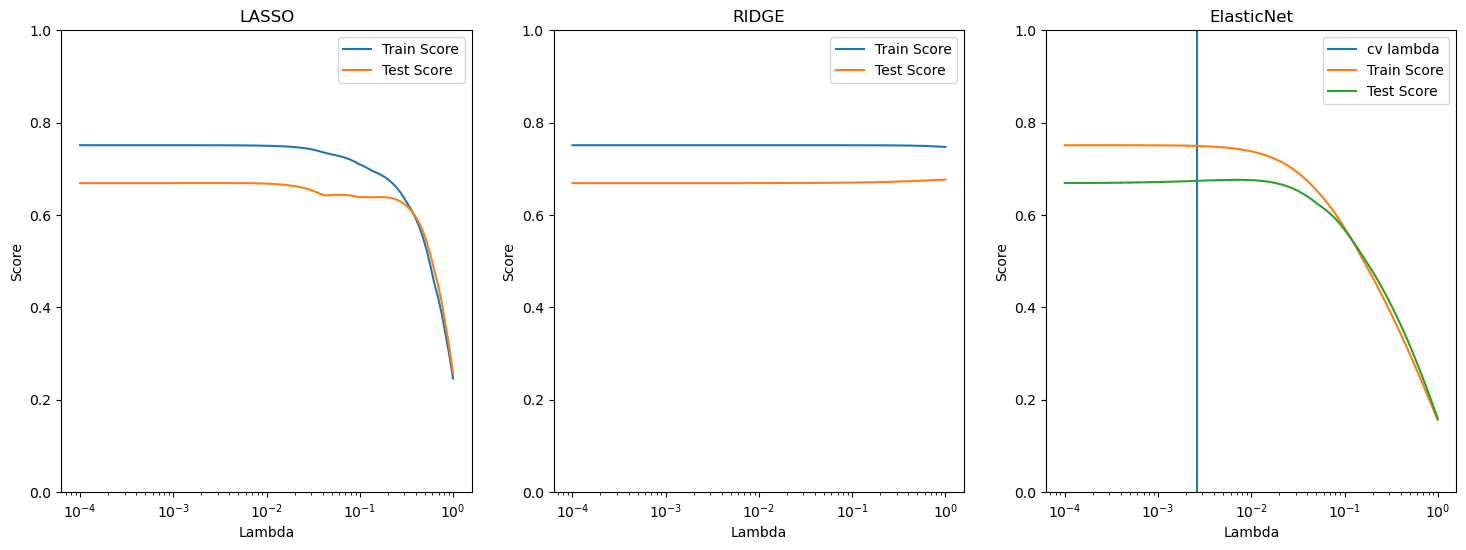

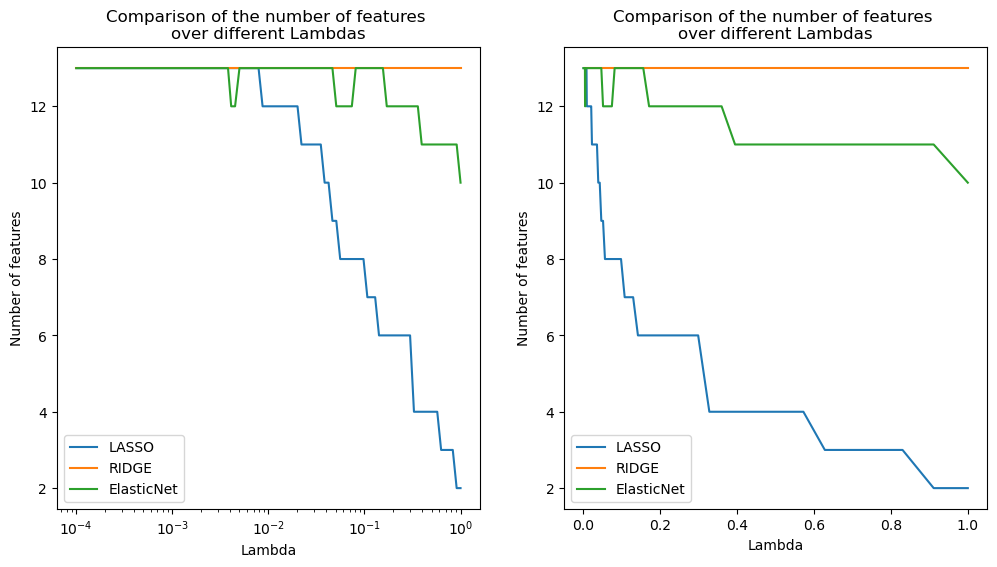

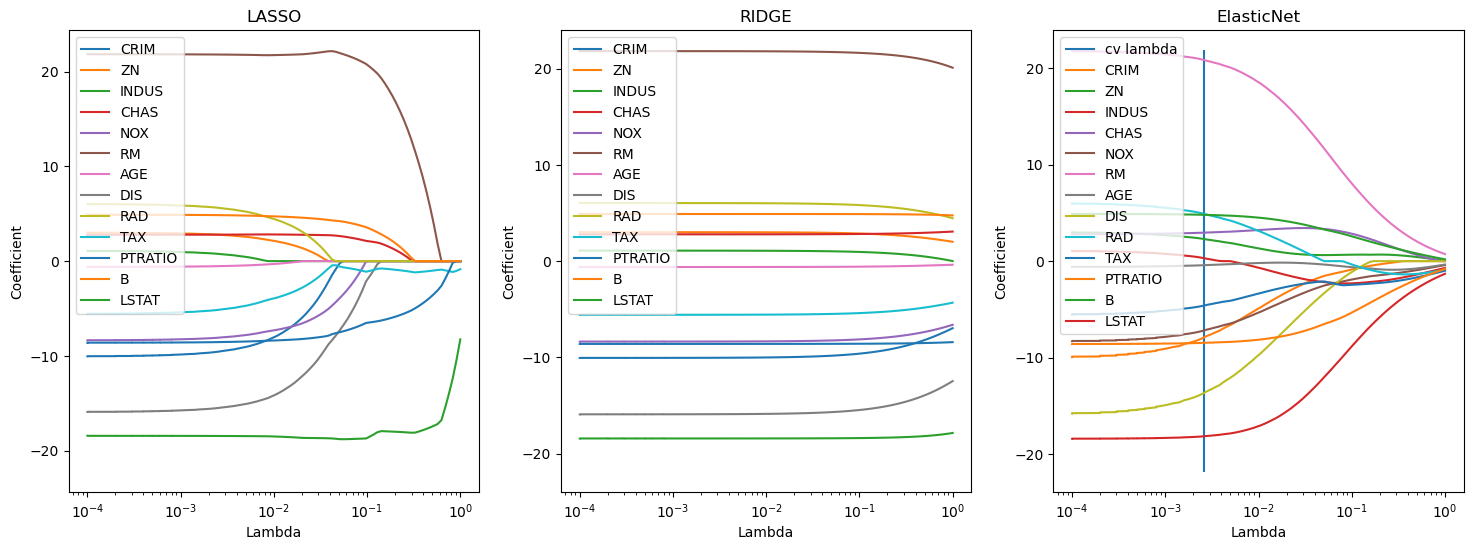

The cross validated elastic net result:
Train Score: 0.7495
Test Score: 0.6734
L1 Ratio: 0.6
Lambda: 0.0026


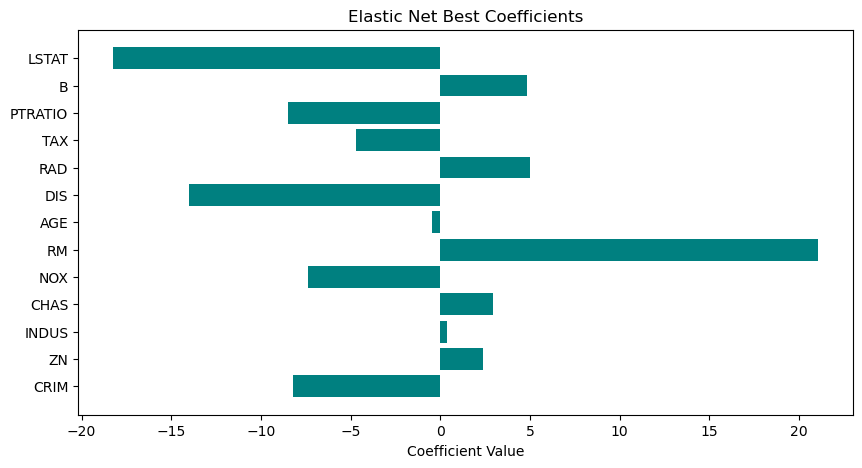

In [25]:
from sklearn.datasets import fetch_openml
import numpy as np
#wilt = fetch_openml('mnist_784', version=1, as_frame=True)
boston = fetch_openml('boston', version=1, as_frame=True)
X = boston.data
y = boston.target
feature_names = boston.feature_names
compare(X,y,feature_names)

An L1 ratio of 0.6 means that 60% of the regularization is L1 (lasso), favoring sparsity (setting coefficients to zero), and 40% is L2 (ridge), which tends to distribute penalties across all coefficients more evenly. This setting influences the number and values of the coefficients in the model: a higher L1 ratio increases the number of coefficients that are exactly zero, promoting a simpler, sparser model.

Lambda is the parameter that controls the overall strength of the regularization. A lower value of lambda (0.0026 in this case) suggests less aggressive regularization, allowing the model to fit more closely to the training data.

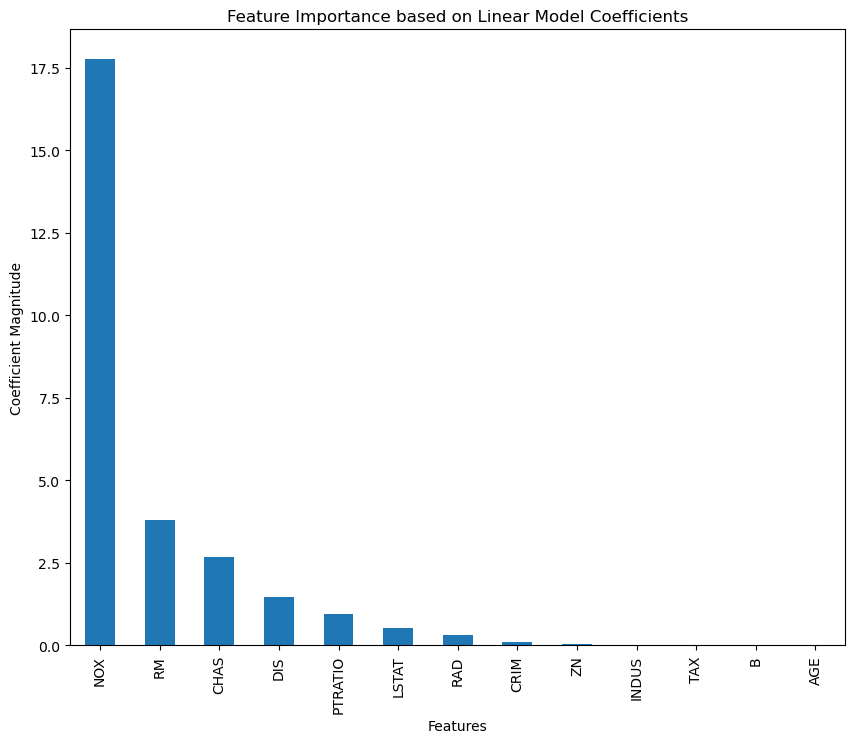

In [26]:
important_features(X, y, feature_names)

**NOX** (Nitric Oxides concentration): The NOX feature has the largest coefficient, indicating a strong relationship with housing prices. In urban planning and environmental studies, it's well-established that higher concentrations of pollutants can decrease the desirability of an area, leading to lower property values.

**RM** (Average number of rooms per dwelling): This feature typically has a direct relationship with house prices. More rooms usually indicate more space, which directly translates to a higher price.

C:\Users\WANG-\AppData\Local\Temp\ipykernel_19956\1607509820.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


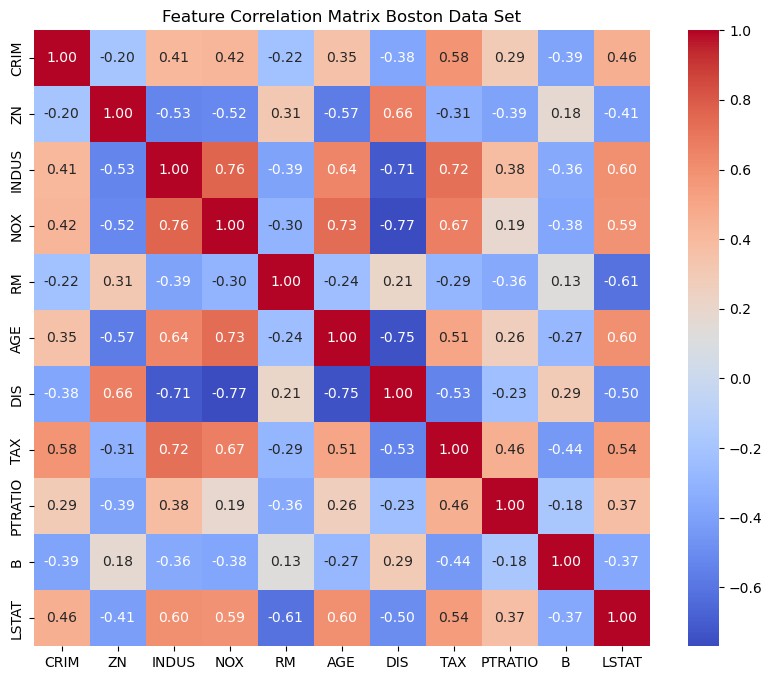

In [27]:
### Correlation of differnet features
df_boston = boston.data
heatmap(df_boston, 'Boston Data Set')

**Potential Insights:** The matrix suggests potential relationships that could be investigated further, such as:
- A strong positive correlation between NOX and INDUS, which might suggest that as industrial activity (INDUS) increases, air pollution (NOX) also increases.
- A strong negative correlation between DIS and INDUS, which could indicate that as the distance from employment centers increases, the level of industrial activity decreases.

**Consistency with Domain Knowledge:** The correlations match what one might expect. For example, TAX (tax rate) and RAD (accessibility to highways) tend to be positively correlated as areas with better transportation infrastructure may have higher taxes.

The two most important features in linear regression are NOX and RM. But, in the Elastic Net model, the most significant coefficients are LSTAT and RM. This difference is primarily due to the correlations between these features, as demonstrated by the heatmap.